In [1]:
import pathlib
import pandas as pd
import re
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import shutil

In [2]:
root_dir = pathlib.Path("../data/Cityscapes/").resolve()
root_dir

PosixPath('/mnt/data/Cityscapes')

In [3]:
leftImg8bit_path, gtFine_path = list(root_dir.iterdir())

# Make training dataset

In [4]:
pattern_real = re.compile('leftImg8bit.png')
pattern_inst = re.compile('gtFine_instanceIds.png')
pattern_label = re.compile('gtFine_labelIds.png')

save_parent = pathlib.Path("./datasets/cityscapes")
if save_parent.exists():
    shutil.rmtree(save_parent)
    print("remove dir:", save_parent)

for phase in ["train", "val"]:

    func = lambda path: path.name
    city_names = list(map(func, list((gtFine_path / phase).iterdir())))

    path_df = pd.DataFrame(
        columns=["real_images_path", "instance_path", "label_path"])

    for city_name in city_names:
        # make dataframe of path.
        real_images_path = [
            path for path in (
                leftImg8bit_path / phase / city_name).glob("*leftImg8bit.png")
        ]
        real_images_path.sort()

        instance_path = [
            path for path in (
                gtFine_path / phase / city_name).glob("*instanceIds.png")
        ]
        instance_path.sort()

        label_path = [
            path
            for path in (gtFine_path / phase / city_name).glob("*labelIds.png")
        ]
        label_path.sort()

        path_dic = {
            "real_images_path": real_images_path,
            "instance_path": instance_path,
            "label_path": label_path
        }
        path_df_city = pd.DataFrame(path_dic)

        # check whether put path in the right order.
        for i, row in path_df_city.iterrows():
            real = re.sub(pattern_real, "", str(row[0].name))
            inst = re.sub(pattern_inst, "", str(row[1].name))
            label = re.sub(pattern_label, "", str(row[2].name))
            assert (real == inst ==
                    label), "wrong pair, index:{}, Got {}, {}, {}".format(
                        i, real, inst, label)
        path_df = pd.concat((path_df, path_df_city))
    print(phase, len(path_df))
    save_path = pathlib.Path(
        "./datasets/cityscapes/{0}/cityscapes_{0}.csv".format(
            phase)).resolve()
    for path in list(save_path.parents)[::-1]:
        if not path.exists():
            path.mkdir()
    path_df.to_csv(save_path, index=False)

train 2975
val 500


# confirm

In [5]:
def get_edges(t):
    edge = torch.ByteTensor(t.size()).zero_()
    edge[:, 1:] = edge[:, 1:] | (t[:, 1:] != t[:, :-1])
    edge[:, :-1] = edge[:, :-1] | (t[:, 1:] != t[:, :-1])
    edge[1:, :] = edge[1:, :] | (t[1:, :] != t[:-1, :])
    edge[:-1, :] = edge[:-1, :] | (t[1:, :] != t[:-1, :])
    return edge.float()

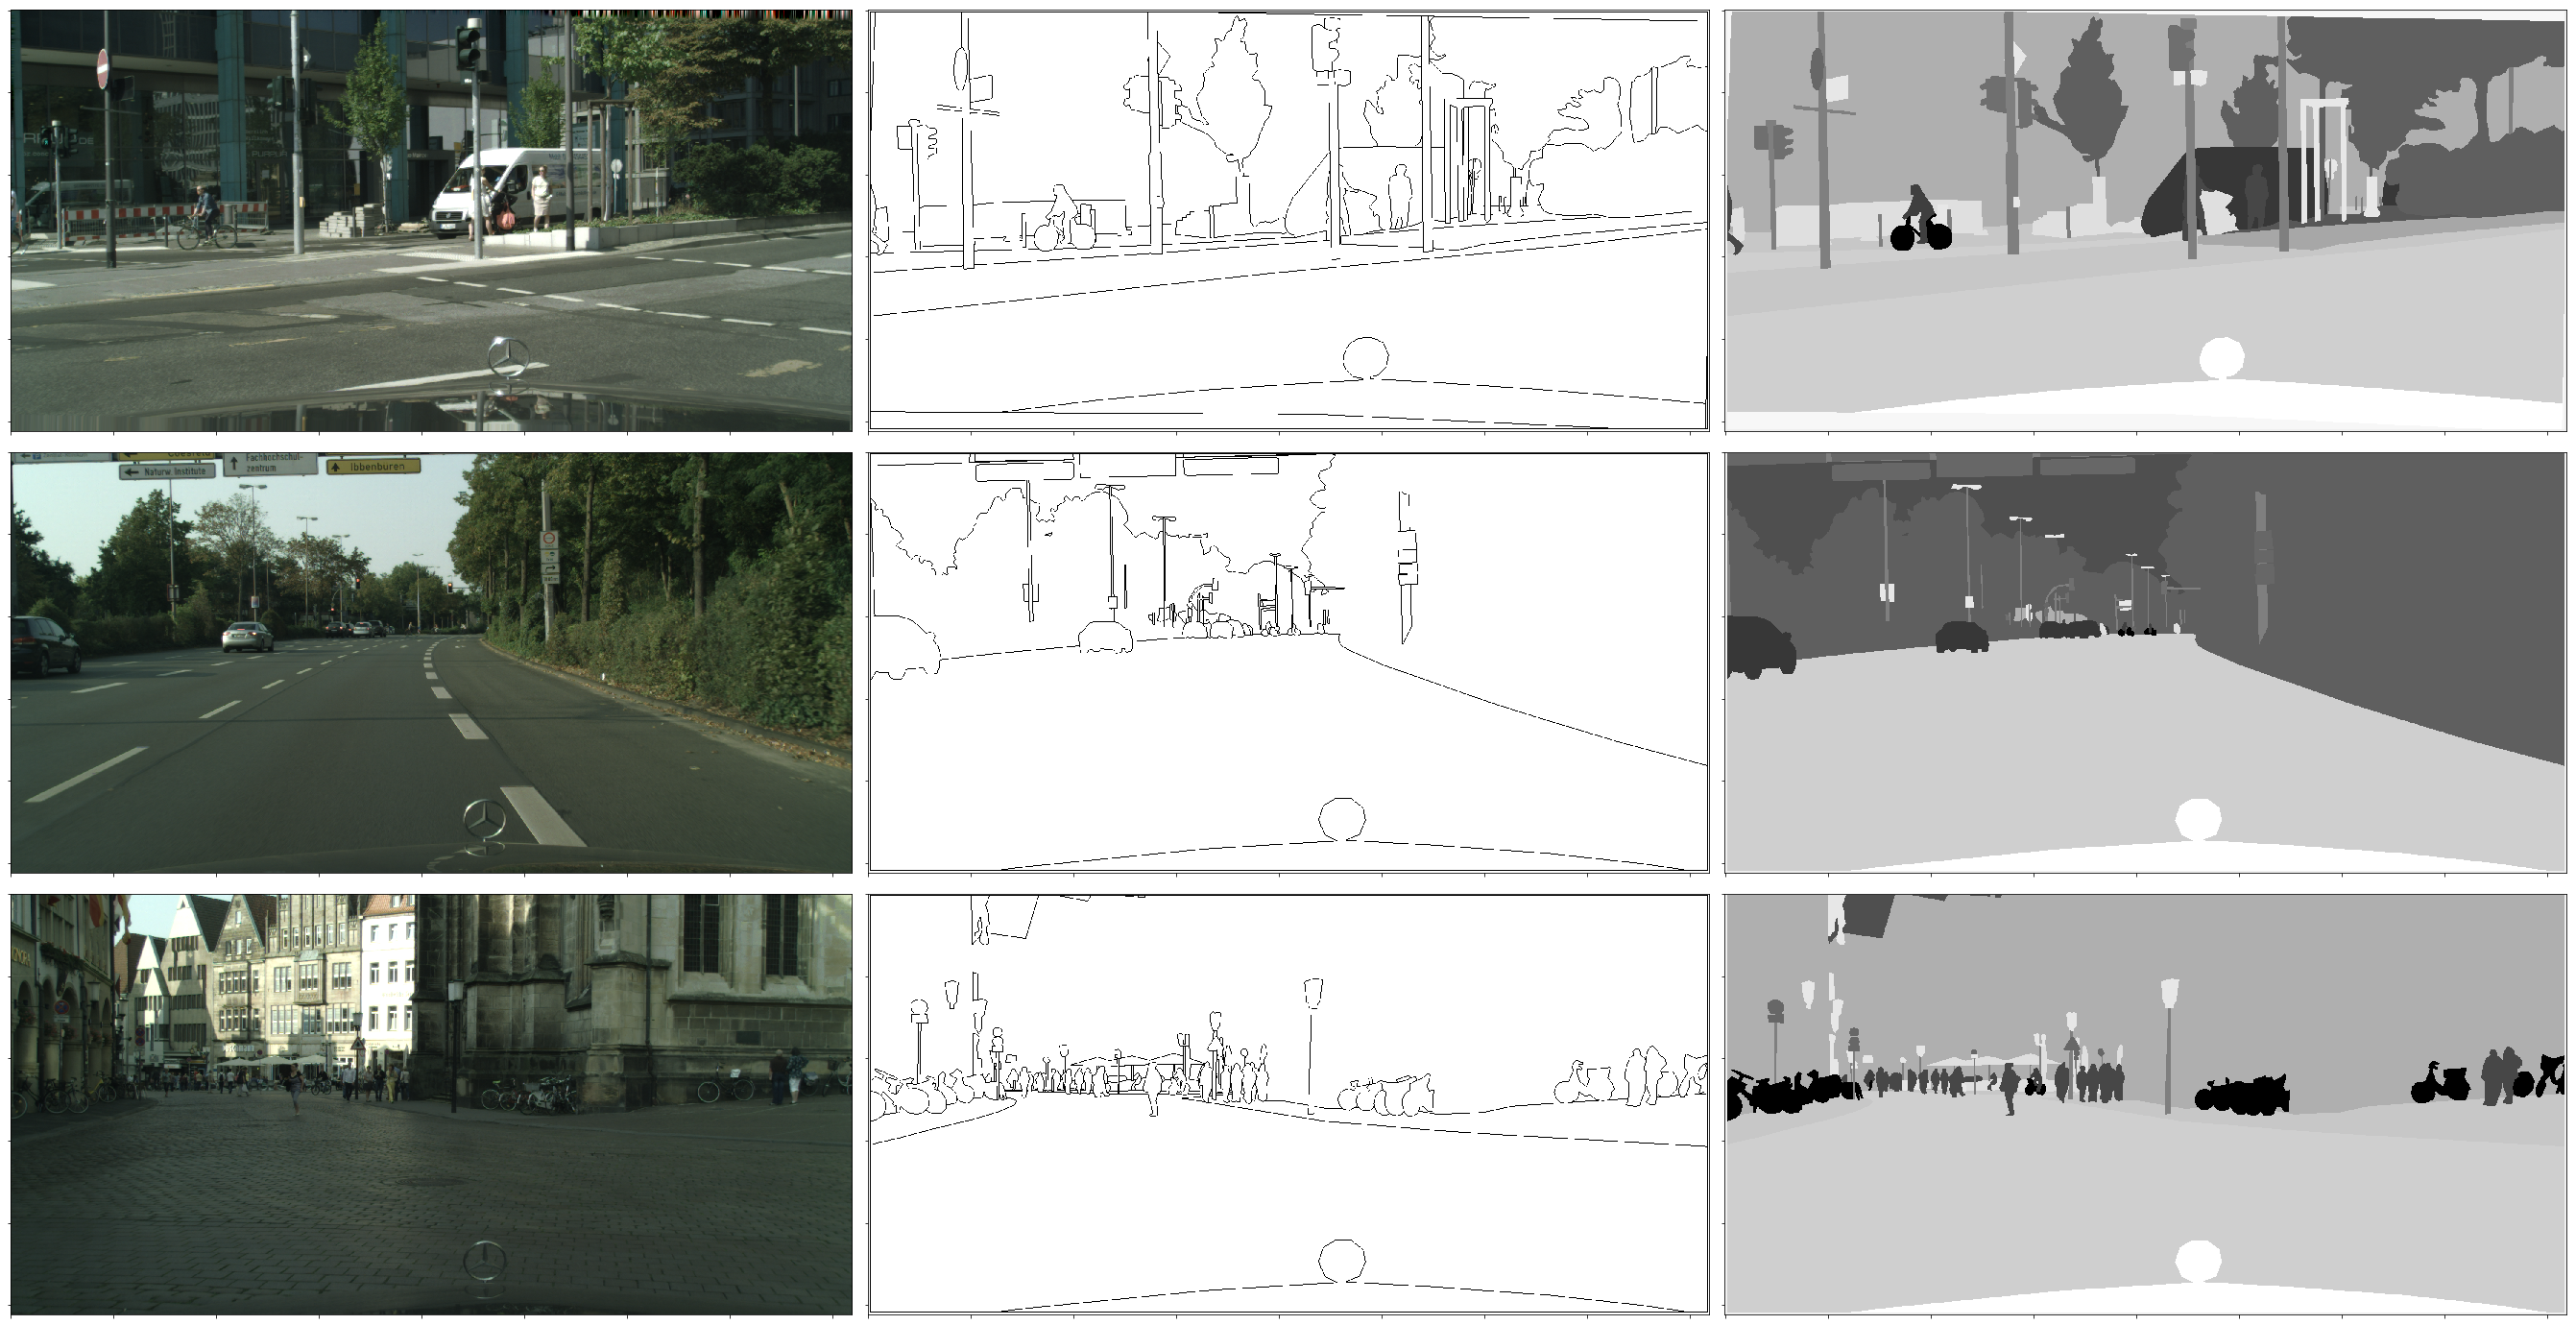

In [7]:
n = 3
phase="val"

index = np.random.randint(0, len(path_df), n)
index = path_df.index[index]
fig, axes = plt.subplots(n, 3, figsize=(48, 25))
save_path = pathlib.Path(
        "./datasets/cityscapes/{0}/cityscapes_{0}.csv".format(
            phase)).resolve()
path_df = pd.read_csv(save_path)
for axis, (i, row) in zip(axes, path_df.iloc[index].iterrows()):
    for i in range(3):
        if i != 1:
            image = np.array(Image.open(row[i]))
        else:
            image = np.array(Image.open(row[i]))
            image = get_edges(torch.tensor(image))
        if len(image.shape) == 2:
            axis[i].imshow(image, cmap=plt.cm.gray_r)
        else:
            axis[i].imshow(image)
        # Turn off tick labels
        axis[i].set_yticklabels([])
        axis[i].set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0.05)
#fig.savefig("example_data.png", bbox_inches='tight', pad_inches=0, dpi=500)